### Imports

In [1]:
import os
import cv2
import json
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.transforms.v2 import RandomHorizontalFlip, RandomRotation, AutoAugment, GaussianBlur, FiveCrop, Resize
import random
from PIL import Image
from tqdm import tqdm
from typing import List
from collections import namedtuple
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose
import torchvision.transforms.v2.functional as T

In [2]:
!pip install torch-xla


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [3]:
# To run on TPU
import torch_xla.core.xla_model as xm
import torch_xla.distributed.xla_multiprocessing as xmp

/usr/local/lib/python3.10/site-packages/torch_xla/__init__.py:202: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


### Labels

In [4]:
#--------------------------------------------------------------------------------
# Definitions
#--------------------------------------------------------------------------------

# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).

    'trainId'     , # An integer ID that overwrites the ID above, when creating ground truth
                    # images for training.
                    # For training, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )


#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

# Please adapt the train IDs as appropriate for you approach.
# Note that you might want to ignore labels with ID 255 during training.
# Make sure to provide your results using the original IDs and not the training IDs.
# Note that many IDs are ignored in evaluation and thus you never need to predict these!

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'ground'          , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'ground'          , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'ground'          , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'ground'          , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , 34 ,       19 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

# function to get the label from the name
def find_label(name):
    for label in labels:
        if label.name == name:
            return label.trainId, label.color
    return 255, (0,0,0)

### Loading Data

In [5]:
#For Working Within Kaggle - Seif
#--------------------------------------------------------------------------------
train_images_folder = '/kaggle/input/cityscapes-segmentation/images/train'
train_labels_folder = '/kaggle/input/cityscapes-segmentation/labels/train'

training_csv_file_path = '/kaggle/working/cityscapes_training.csv'
val_csv_file_path = '/kaggle/working/cityscapes_val.csv'
#--------------------------------------------------------------------------------

#For Working Locally - Youssif
#--------------------------------------------------------------------------------
# current_dir = os.path.dirname(os.getcwd())
# train_images_folder = os.path.join(current_dir, 'DataSet\\Images\\Train_Set')
# train_labels_folder = os.path.join(current_dir, 'DataSet\\Labels\\train')

# training_csv_file_path = os.path.join(current_dir, 'DataSet\\cityscapes_training.csv')
# val_csv_file_path = os.path.join(current_dir, 'DataSet\\cityscapes_val.csv')
#--------------------------------------------------------------------------------

data = {
    'image_path': [],
    'label_mask_path': [],
    'label_json_path': []
}

for city in os.listdir(train_images_folder):
    city_image_folder = os.path.join(train_images_folder, city)
    city_label_folder = os.path.join(train_labels_folder, city)
    # print(f"Processing {city} ...")
    
    if os.path.isdir(city_image_folder):
        for image_file in os.listdir(city_image_folder):
            # print(f"Processing {image_file} ...")
            if image_file.endswith('_leftImg8bit.png'):
                image_name_base = image_file.replace('_leftImg8bit.png', '')
                label_mask_file = f"{image_name_base}_gtFine_labelTrainIds.png"
                label_json_file = f"{image_name_base}_gtFine_polygons.json"
                
                data['image_path'].append(os.path.join(city_image_folder, image_file))
                data['label_mask_path'].append(os.path.join(city_label_folder, label_mask_file))
                data['label_json_path'].append(os.path.join(city_label_folder, label_json_file))

df = pd.DataFrame(data)

train_df, val_df = train_test_split(df, test_size=0.2, random_state=23, shuffle=True)

train_df.to_csv(training_csv_file_path, index=False)
val_df.to_csv(val_csv_file_path, index=False)

In [6]:
#For Working Within Kaggle - Seif
#--------------------------------------------------------------------------------
test_images_folder = '/kaggle/input/cityscapes-segmentation/images/test'

test_csv_file_path = '/kaggle/working/cityscapes_test.csv'
#--------------------------------------------------------------------------------

#For Working Locally - Youssif
#--------------------------------------------------------------------------------
# test_images_folder = os.path.join(current_dir, 'DataSet\\Images\\Test_Set')

# test_csv_file_path = os.path.join(current_dir, 'DataSet\\cityscapes_test.csv')
#--------------------------------------------------------------------------------

test_data = {
    'image_path': []
}

for city in os.listdir(test_images_folder):
    city_image_folder = os.path.join(test_images_folder, city)
    
    if os.path.isdir(city_image_folder):
        for image_file in os.listdir(city_image_folder):
            if image_file.endswith('_leftImg8bit.png'):
                test_data['image_path'].append(os.path.join(city_image_folder, image_file))

test_df = pd.DataFrame(test_data)

test_df.to_csv(test_csv_file_path, index=False)

### EDA

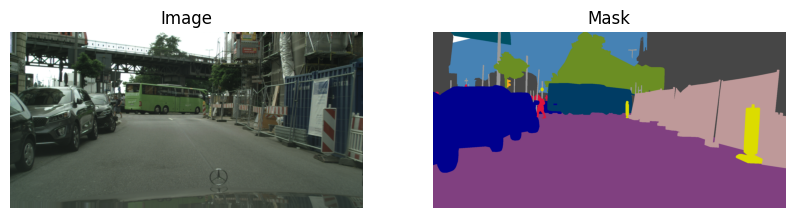

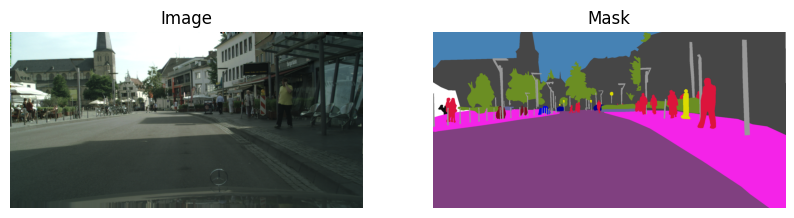

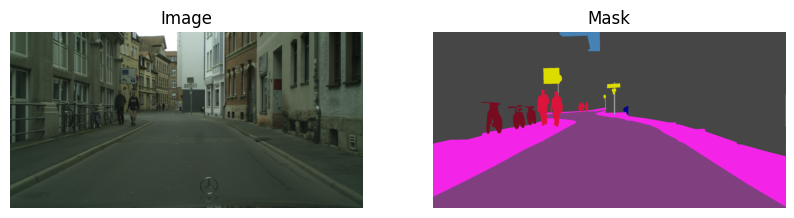

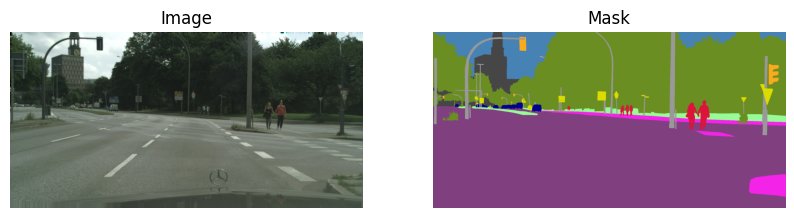

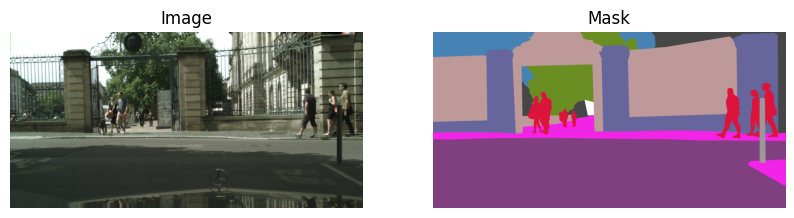

In [7]:
# Displaying A Sample of Images and Masks
def show_img_mask(row):
    image = cv2.cvtColor(cv2.imread(row['image_path']), cv2.COLOR_BGR2RGB)
    mask = cv2.imread(row['label_mask_path'])

    json_data = json.load(open(row['label_json_path']))

    for obj in json_data['objects']:
        label = obj['label']
        trainId, color = find_label(label)
        if trainId != 255:
            mask = cv2.fillPoly(mask, np.array([obj['polygon']], dtype=np.int32), color)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image)
    ax[0].axis('off')
    ax[0].set_title('Image')
    ax[1].imshow(mask, cmap='gray')
    ax[1].axis('off')
    ax[1].set_title('Mask')
    plt.show()

rSample = train_df.sample(5)
for index, row in rSample.iterrows():
    show_img_mask(row)

In [8]:
# # Analyzing the Distribution of the Labels accross the train Dataset
# labels_freq = {label.name: 0 for label in labels}
# labels_not_found = {}

# dimensions_freq = {}

# for index, row in train_df.iterrows():
#     json_data = json.load(open(row['label_json_path']))
    
#     dimensions = f"{json_data['imgWidth']}x{json_data['imgHeight']}"
#     dimensions_freq[dimensions] = dimensions_freq.get(dimensions, 0) + 1

#     for obj in json_data['objects']:
#         label = obj['label']
#         if label in labels_freq:
#             labels_freq[label] += 1
#         else:
#             if label not in labels_not_found:
#                 labels_not_found[label] = 1
#             else:
#                 labels_not_found[label] += 1
        
# plt.figure(figsize=(20, 10))
# plt.bar(labels_freq.keys(), labels_freq.values())
# plt.xticks(rotation=90)
# plt.show()
# print(labels_not_found)

In [9]:
# Pixels Covered by Each Label
# def get_labels_pixels(row):
#     mask = cv2.imread(row['label_mask_path'])
#     json_data = json.load(open(row['label_json_path']))

#     for obj in json_data['objects']:
#         label = obj['label']
#         trainId, color = find_label(label)
#         if trainId != 255:
#             mask = cv2.fillPoly(mask, np.array([obj['polygon']], dtype=np.int32), color)

#     return mask

# train_df['label_mask'] = train_df.apply(get_labels_pixels, axis=1)

# labels_pixels = {label.name: 0 for label in labels if label.trainId != 255}
# labels_pixels['Others'] = 0

# for index, row in train_df.iterrows():
#     for label in labels:
#         if label.trainId != 255:
#             labels_pixels[label.name] += np.sum((row['label_mask'][:,:,0] == label.color[0]) &
#                                                 (row['label_mask'][:,:,1] == label.color[1]) &
#                                                 (row['label_mask'][:,:,2] == label.color[2]))
#         else:
#             labels_pixels['Others'] += np.sum((row['label_mask'][:,:,0] == label.color[0]) &
#                                               (row['label_mask'][:,:,1] == label.color[1]) &
#                                               (row['label_mask'][:,:,2] == label.color[2]))

# plt.figure(figsize=(20, 10))
# plt.bar(labels_pixels.keys(), labels_pixels.values())
# plt.xticks(rotation=90)
# plt.show()

In [10]:
# Bar Plot for the Dimensions of the Images
# plt.figure(figsize=(10, 10))
# plt.bar(dimensions_freq.keys(), dimensions_freq.values())
# plt.xticks(rotation=90)
# plt.show()

# All Images have the same dimensions

### PreProcessing & Augmentation

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [12]:
# augmented_data={
#     'image_path': [],
#     'label_mask_path': [],
#     'label_json_path': []
# }

# target_labels = {'bus', 'rider', 'truck', 'terrain', 'wall', 'building', 'road', 'motorcycle', 'bicycle','fence','license plate'}

# image_paths_with_labels = []
# i=0

# for index, row in train_df.iterrows():
#             json_data = json.load(open(row['label_json_path']))
            
# #             has_target_label = any(obj['label'] in target_labels for obj in json_data['objects'])
#             target_label_count = sum(1 for obj in json_data['objects'] if obj['label'] in target_labels)
#             if target_label_count>12:
#                 augmented_data['image_path'].append(row['image_path'])
#                 augmented_data['label_mask_path'].append(row['label_mask_path'])
#                 augmented_data['label_json_path'].append(row['label_json_path'])
                

# df_augmented=pd.DataFrame(augmented_data)
# print(f'Found {len(df_augmented)} images containing the specified labels:')


In [13]:
#TODO : TRAIN DATA PREPROCESSING PIPELINE
csv_keys = ['image_path', 'label_mask_path', 'label_json_path']

In [14]:
class toTensor:
    def __call__(self, sample):
        image, mask = sample
        
        imageTensor = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
        
        if mask:
            mask_arr = np.array(mask)
            mask_arr[mask_arr > 19] = 20

            num_classes = 21
            mask_one_hot = np.eye(num_classes)[mask_arr]

            mask_one_hot = np.transpose(mask_one_hot, (2, 0, 1))
            maskTensor = torch.tensor(mask_one_hot, dtype=torch.float32) / 255.0
            
        return imageTensor, maskTensor

In [15]:
class horizontalFlip:
    def __init__(self, prob = 0.5):
        self.p = prob
    
    def __call__(self, sample):
        image, mask = sample
        
        if torch.rand(1).item() < self.p: 
            imageFlipped = T.functional.horizontal_flip(image)
            if mask:
                maskFlipped = T.functional.horizontal_flip(mask)
        
        return imageFlipped, maskFlipped

In [16]:
class randomRotation:
    def __init__(self, angle, prob = 0.5):
        self.p = prob
        self.a = angle
    
    def __call__(self, sample):
        image, mask = sample
        
        if torch.rand(1).item() < self.p: 
            angle = torch.randint(-self.a, self.a, (1,)).item()
            
            imageRotated = T.functional.rotate(image, angle)
            if mask:
                maskRotated = T.functional.rotate(mask, angle)
        
        return imageRotated, maskRotated

In [17]:
class gaussianBlur:
    def __call__(self, sample):
        image, mask = sample
            
        imageBlured = T.functional.gaussian_blur(image, 1)
        if mask:
            maskBlured = T.functional.gaussian_blur(image, 1)
        
        return imageBlured, maskBlured

In [18]:
class autoContrast:
    def __call__(self, sample):
        image, mask = sample
            
        Nimage = T.functional.autocontrast(image)
        if mask:
            Nmask = T.functional.autocontrast(image)
        
        return Nimage, Nmask

In [19]:
class VCROP:
    def __call__(self, sample):
        image, mask = sample
        
        five_crop = T.FiveCrop(size=(512, 256))
        
        image_crops = five_crop(image)
        mask_crops = five_crop(mask)
        
        to_tensor = toTensor()

        image_crops_tensor = [to_tensor(crop) for crop in image_crops]
        mask_crops_tensor = [to_tensor(crop) for crop in mask_crops]
        
        return image_crops_tensor, mask_crops_tensor

In [20]:
class ImageToTensor:
    def __call__(self, image):
        image_np = np.array(image)
        
        image_np = np.transpose(image_np, (2, 0, 1))
        
        imageTensor = torch.tensor(image_np, dtype=torch.float32) / 255.0
        
        return imageTensor
    
class MaskToTensor:
    def __call__(self, mask):
        mask_arr = np.array(mask)
        mask_arr[mask_arr > 19] = 20

        num_classes = 21
        mask_one_hot = np.eye(num_classes)[mask_arr]

        mask_one_hot = np.transpose(mask_one_hot, (2, 0, 1))
        maskTensor = torch.tensor(mask_one_hot, dtype=torch.float32)
        
        return maskTensor

In [21]:
class CustomSegmentationAugmentation:
    def __init__(self, crop_size=(512, 256)):
        self.five_crop = FiveCrop(crop_size)
        self.h_flip = RandomHorizontalFlip(p=0.5)
        self.rotation = RandomRotation(degrees=12)
        self.auto_contrast = AutoAugment()
        self.gaussian_blur = GaussianBlur(1)
        self.image_to_tensor = ImageToTensor()
        self.mask_to_tensor = MaskToTensor()
        self.resize = Resize(crop_size)

    def __call__(self, image, mask):
        # Apply FiveCrop to both image and mask
        image_crops = self.five_crop(image)
        mask_crops = self.five_crop(mask)

        augmented_images = []
        augmented_masks = []
        # Add the original image and mask (resized to (512, 256)) to the augmented set
        image = image.resize((256, 512))
        mask = mask.resize((256, 512))
        
        augmented_images.append(self.image_to_tensor(image))
        augmented_masks.append(self.mask_to_tensor(mask))

        # Loop through the crops and apply augmentations
        for img, msk in zip(image_crops, mask_crops):
            # Apply Horizontal Flip (use the same transformation for both image and mask)
            if random.random() < 0.5:  
                img = T.hflip(img)
                msk = T.hflip(msk)
            
            # Apply Random Rotation (use the same angle for both image and mask)
#             angle = random.uniform(-12, 12) 
#             img = T.rotate(img, angle)
#             msk = T.rotate(msk, angle)
            
            # Apply AutoContrast and GaussianBlur to the image only
#             img = self.auto_contrast(img)
            img = self.gaussian_blur(img)
        
            img = self.resize(img)
            msk = self.resize(msk)
        
            # Convert both image and mask to tensors
            img_tensor = self.image_to_tensor(img)
            msk_tensor = self.mask_to_tensor(msk)

            augmented_images.append(img_tensor)
            augmented_masks.append(msk_tensor)

        return augmented_images, augmented_masks

In [22]:
def augment_image_and_mask(image, mask):
    
    if torch.rand(1).item() < 0.5:  
        image = T.functional.horizontal_flip(image)
        mask = T.functional.horizontal_flip(mask)
        
    if torch.rand(1).item() < 0.5:
        angle = torch.randint(-12, 12, (1,)).item()
        image = T.functional.rotate(image, angle)
        mask = T.functional.rotate(mask, angle)
        
    image = T.functional.adjust_contrast(image, 2)
    mask = T.functional.adjust_contrast(mask, 2)
    
    image = T.functional.gaussian_blur(image, 1)
    mask = T.functional.gaussian_blur(mask, 1)

    return image, mask

In [23]:
# class Dataset(Dataset):
#     def __init__(self, input_dataframe: pd.DataFrame, KeysOfInterest: List[str], mask=True, aug = True): # TODO: add parameters if needed
#         self.koi = KeysOfInterest
#         self.input_dataframe = input_dataframe[self.koi]
#         self.mask_state = mask
#         self.aug_state = aug

#     def __getitem__(self, item: int):
#         img_path = self.input_dataframe.iloc[item]['image_path']
        
#         # Read the image
#         image = Image.open(img_path).convert("RGB") 
#         image = image.resize((512,256))
        
#         mask = None
        
#         if self.mask_state:
#             mask_path = self.input_dataframe.iloc[item]['label_mask_path']
#             mask = Image.open(mask_path).convert("L")
#             mask = mask.resize((512,256))
            
#             if self.aug_state:
#                 image, mask = augment_image_and_mask(image, mask)
            
#             mask_arr = np.array(mask)
#             mask_arr[mask_arr > 19] = 20

#             # One-hot encoding
#             num_classes = 21
#             mask_one_hot = np.eye(num_classes)[mask_arr]

#         # Optionally: permute the mask from (H, W, 21) to (21, H, W) if you need that for your model
#             mask_one_hot = np.transpose(mask_one_hot, (2, 0, 1))
#             mask = torch.tensor(mask_one_hot, dtype=torch.float32)
#             image = ToTensor()(image)
        
#         return image, mask 
        
#     def __len__(self):
#         return len(self.input_dataframe)

In [24]:
class Dataset(Dataset):
    def __init__(self, input_dataframe, KeysOfInterest, transform=None, mask = True):
        self.input_dataframe = input_dataframe[KeysOfInterest]
        self.transform = transform
        self.mask_state = mask

    def __getitem__(self, idx):
        img_path = self.input_dataframe.iloc[idx]['image_path']
        mask = None
        
        if self.mask_state:
            mask_path = self.input_dataframe.iloc[idx]['label_mask_path']
        
        image = Image.open(img_path).convert("RGB")
        if self.mask_state:
            mask = Image.open(mask_path).convert("L")
        
        if self.transform:
            image_crops, mask_crops = self.transform(image, mask)
            
            image_batch = torch.stack(image_crops)  
            mask_batch = torch.stack(mask_crops)
            
            return image_batch, mask_batch
        
        image = image.resize((512, 256))
        if mask:
            mask = mask.resize((512, 256))
        
        return image, mask

    def __len__(self):
        return len(self.input_dataframe)

In [25]:
#TODO : Initilize your datasets
# ds_train=Dataset(input_dataframe=train_df,
#                 KeysOfInterest=csv_keys)

# ds_val=Dataset(input_dataframe=val_df,
#                 KeysOfInterest=csv_keys,
#                 aug = False)

# ds_test=Dataset(input_dataframe=test_df,
#                 KeysOfInterest=["image_path"], 
#                 mask = False)

transform = CustomSegmentationAugmentation(crop_size=(512, 256))

ds_train=Dataset(input_dataframe=train_df,
                KeysOfInterest=csv_keys,
                transform=transform)

ds_val=Dataset(input_dataframe=val_df,
                KeysOfInterest=csv_keys)

ds_test=Dataset(input_dataframe=test_df,
                KeysOfInterest=["image_path"],
               mask = False)

In [26]:
BATCH_SIZE = 1
workers = 4 

dl_train = DataLoader(dataset=ds_train, batch_size= BATCH_SIZE, shuffle=True, num_workers=workers)
dl_val = DataLoader(dataset=ds_val, batch_size= BATCH_SIZE, num_workers=workers, shuffle=True)
#dl_test = DataLoader(dataset=ds_test, batch_size= 1, num_workers=workers, shuffle=False)

Sample 1:


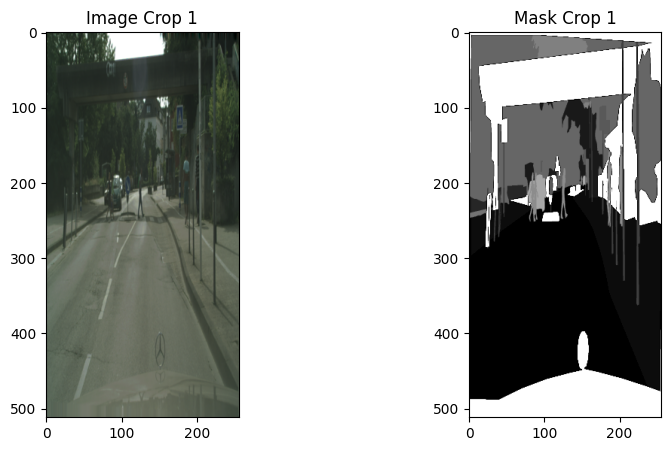

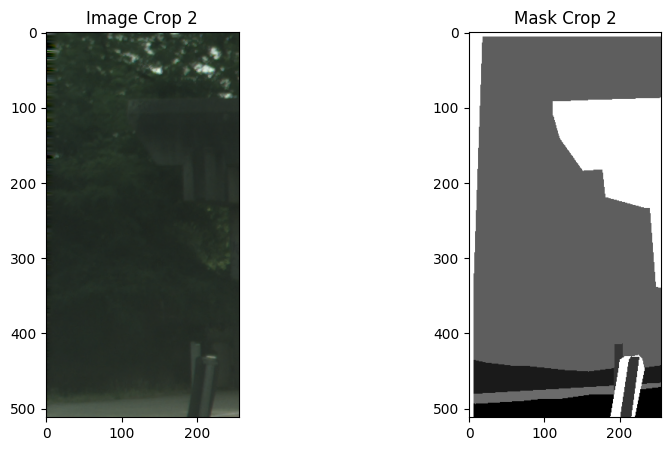

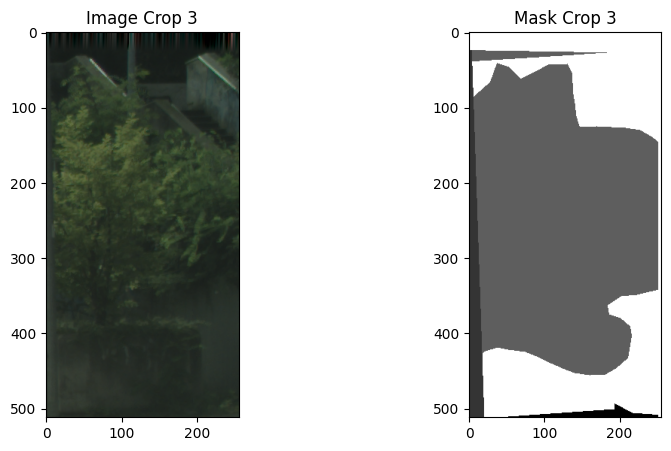

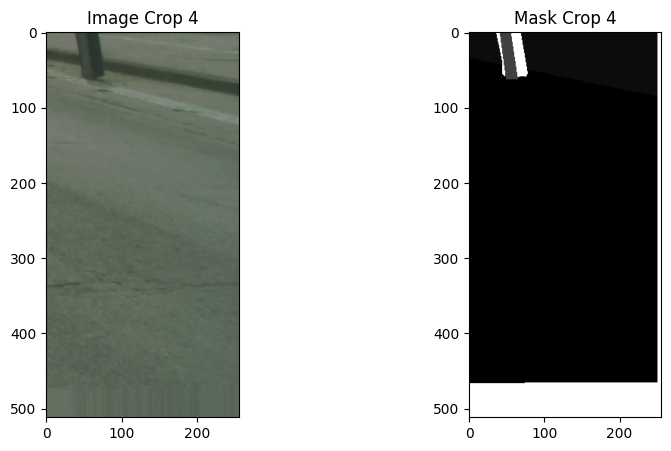

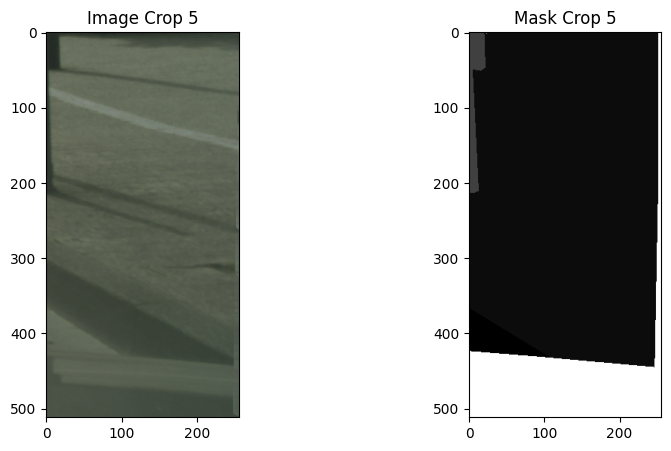

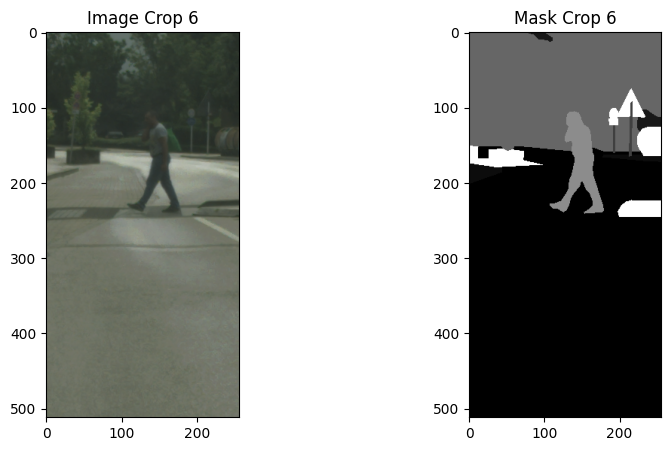

Sample 2:


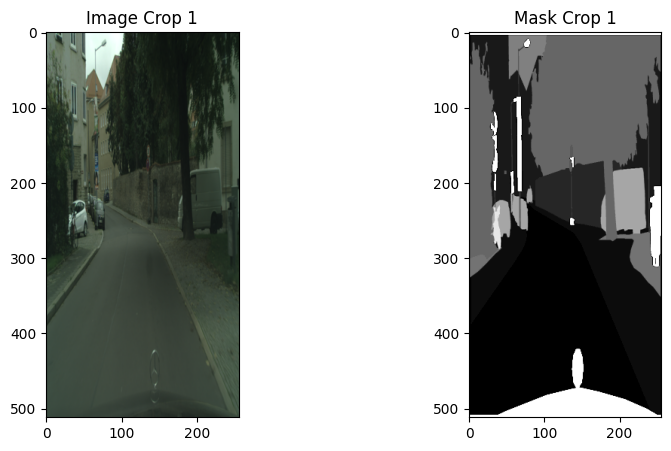

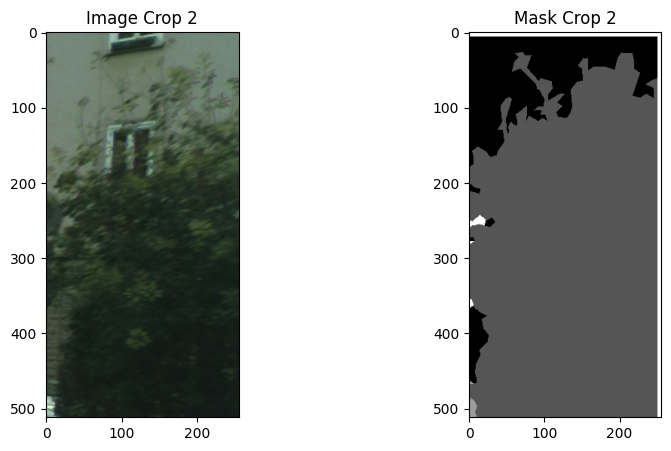

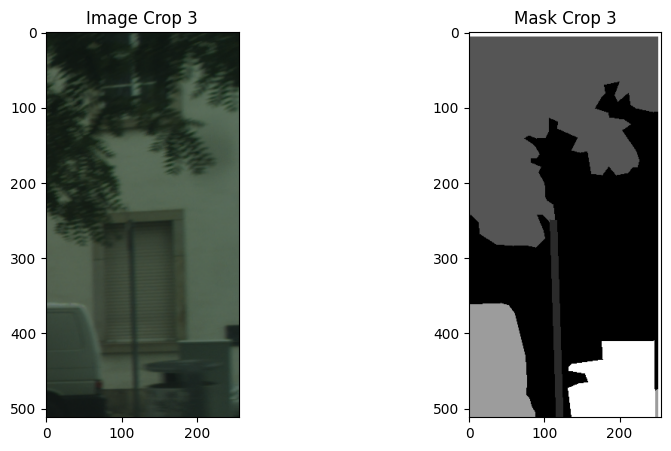

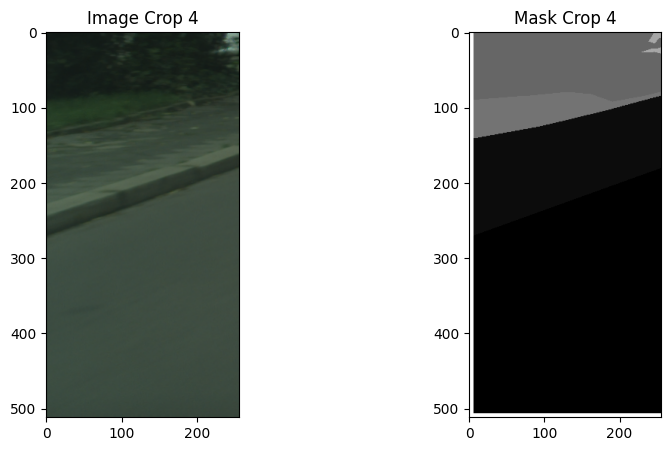

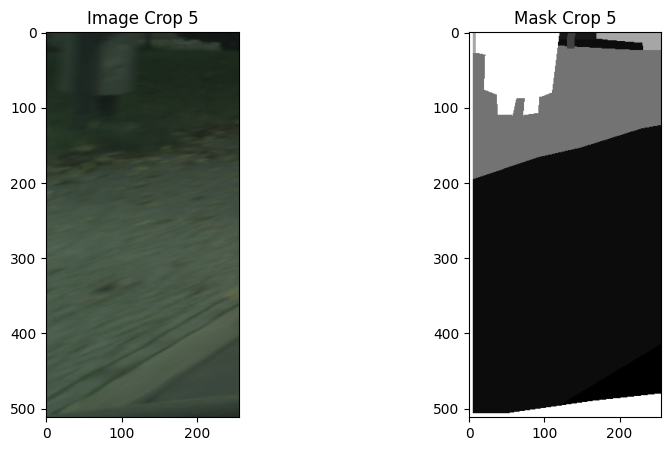

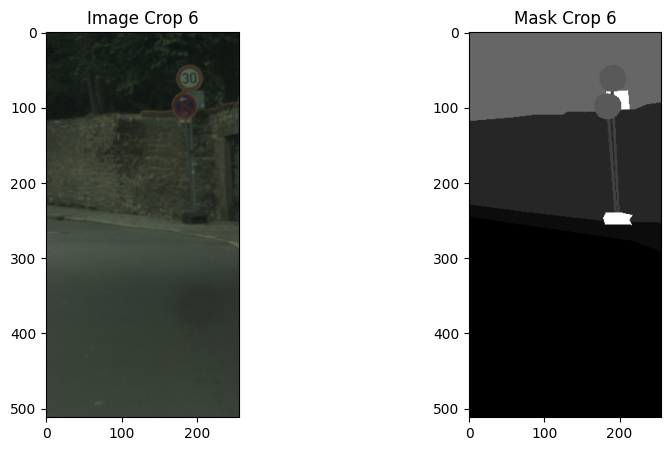

In [27]:
def show_sample(image_tensor, mask_tensor):
    """
    Display a set of images and their corresponding masks.
    This version assumes `image_tensor` and `mask_tensor` are stacks of 5 crops.
    """
    # If the tensors are on GPU, move them to CPU
    if image_tensor.is_cuda:
        image_tensor = image_tensor.cpu()
    if mask_tensor is not None and mask_tensor.is_cuda:
        mask_tensor = mask_tensor.cpu()

    # Iterate through the 5 crops and display them
    num_crops = image_tensor.size(0)  # Assuming shape is (5, C, H, W)
    for i in range(num_crops):
        img_crop = image_tensor[i]  # Get the i-th crop
        mask_crop = mask_tensor[i]  # Get the i-th mask

        # Permute image crop from (C, H, W) to (H, W, C) for visualization
        img = img_crop.permute(1, 2, 0).numpy()

        # Convert mask to single channel for visualization
        mask = torch.argmax(mask_crop, dim=0).numpy()

        # Display image and mask
        plt.figure(figsize=(10, 5))

        # Show the image
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title(f"Image Crop {i + 1}")

        # Show the mask
        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap="gray")
        plt.title(f"Mask Crop {i + 1}")

        plt.show()
    
def show_data_samples(dataloader, num_batch):
    """
    Show all crops from the first `num_batch` batches from the dataloader.
    """
    for i, (image_batch, mask_batch) in enumerate(dataloader):
        if i >= num_batch:  # Stop after the specified number of batches
            break

        batch_size = image_batch.size(0)  # Number of images (stacked with crops) in the batch

        for j in range(batch_size):  # Loop through all images in the batch
            print(f"Sample {i * batch_size + j + 1}:")
            show_sample(image_batch[j], mask_batch[j])

# Example usage to show samples from the training dataloader
show_data_samples(dl_train, 2)

In [28]:
# # Function to show a single sample (image and mask)
# def show_sample(image_tensor, mask_tensor):
#     if image_tensor.is_cuda:
#         image_tensor = image_tensor.cpu()
#     if mask_tensor is not None and mask_tensor.is_cuda:
#         mask_tensor = mask_tensor.cpu()

#     image = image_tensor.permute(1, 2, 0).numpy()
#     mask = torch.argmax(mask_tensor, dim=0).numpy()

#     plt.figure(figsize=(10, 5))
#     plt.subplot(1, 2, 1)
#     plt.imshow(image)
#     plt.axis('off')
#     plt.title('Image')
#     plt.subplot(1, 2, 2)
#     im = plt.imshow(mask, cmap='gray')
#     plt.axis('off')
#     plt.title('Mask')
#     plt.colorbar(im, ax=plt.gca())  # Add color bar to the mask plot
#     plt.show()

# # Function to show multiple samples from a batch
# def show_data_samples(dataloader, num_batch):
#     for i, (image_batch, mask_batch) in enumerate(dataloader):
#         if i >= num_batch:
#             break

#         # print(image_batch[0].shape, mask_batch[0].shape)

#         batch_size = image_batch.size(0)
#         for j in range(batch_size):
#             print(f"Sample {i*batch_size + j + 1}:")
#             show_sample(image_batch[j], mask_batch[j])

# # Example usage to show samples from the training dataloader
# show_data_samples(dl_train, 2)

In [29]:
class Convblock(nn.Module):
    def __init__(self, in_chs, out_chs):
        super().__init__()
        self.convblock = nn.Sequential(
            nn.Conv2d(in_chs, out_chs, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_chs),
            nn.SiLU(inplace=True),
            nn.Conv2d(out_chs, out_chs, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_chs),
            nn.SiLU(inplace=True),
        )

    def forward(self, x):
        return self.convblock(x)

In [30]:
class UNet(nn.Module):

    def __init__(self,in_chs,out_chs,fts=[64,128,256,512]):
        super(UNet, self).__init__()

        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(2, 2)

        # Encoder Network
        for ft in fts:
            self.downs.append(Convblock(in_chs, ft))
            in_chs = ft

        # BottelNeck
        self.neck = Convblock(fts[-1], fts[-1]*2)

        # Decoder Network
        for ft in reversed(fts):
            self.ups.append(nn.ConvTranspose2d(ft*2, ft, 2, 2))
            self.ups.append(Convblock(ft*2, ft))

        self.out = nn.Conv2d(fts[0], out_chs, 1, 1)        

    def forward(self,x):

        skp_conns = []
        for down in self.downs:
            x = down(x)
            skp_conns.append(x)
            x = self.pool(x)
        
        x = self.neck(x)

        skp_conns = skp_conns[::-1]
        for i in range(0, len(self.ups), 2):
            x = self.ups[i](x)
            cnct_skp = torch.cat((x, skp_conns[i//2]), dim=1)
            x = self.ups[i+1](cnct_skp)

        return self.out(x)

In [31]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0 
        else:
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

In [32]:
#TODO : Write the loss function you are going to use

device = xm.xla_device()
model = UNet(in_chs=3,out_chs=21).to(device)

# # Check if multiple GPUs are available
# if torch.cuda.device_count() > 1:
#     print("Using", torch.cuda.device_count(), "GPUs!")
#     # Wrap the model with DataParallel to use multiple GPUs
#     model = nn.DataParallel(model) 

E0000 00:00:1729110005.372907    3561 common_lib.cc:818] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:483


In [33]:
def show(imgs, outputs, labels):

    for img, output, label in zip(imgs, outputs, labels):
    
        # Migrate the data to the cpu
        img = img.cpu()
        output = output.cpu()
        label = label.cpu()
    
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(img.permute(1, 2, 0).numpy())
        plt.axis('off')
        plt.title('Image')

        plt.subplot(1, 3, 2)
        plt.imshow(torch.argmax(output, dim=0).numpy(), cmap='gray')
        plt.axis('off')
        plt.title('Prediction')

        plt.subplot(1, 3, 3)
        plt.imshow(torch.argmax(label, dim=0).numpy(), cmap='gray')
        plt.axis('off')
        plt.title('Ground Truth')

    plt.show()

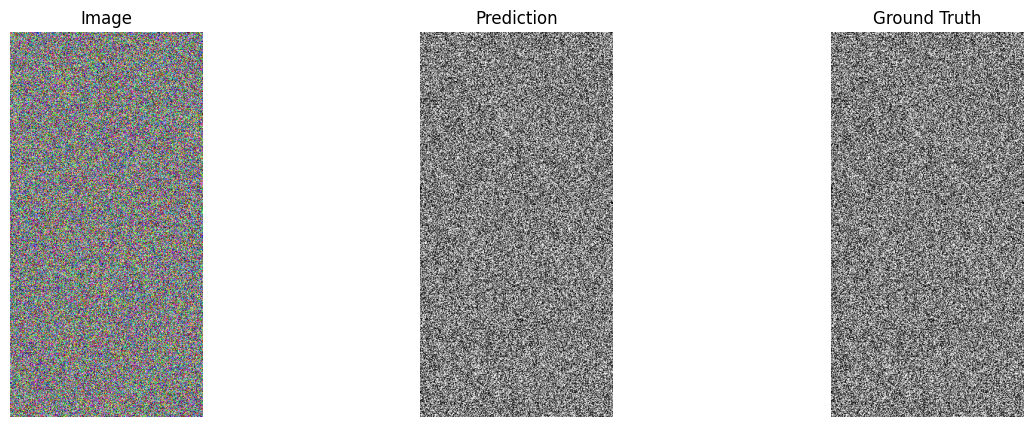

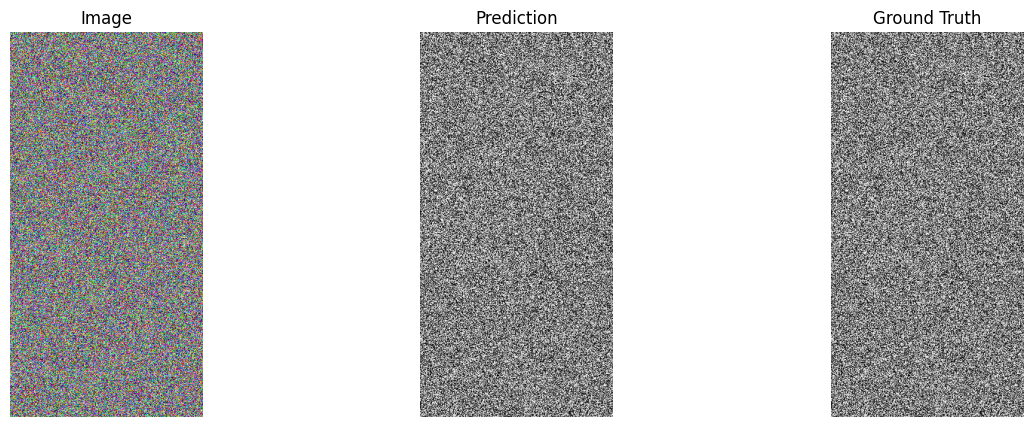

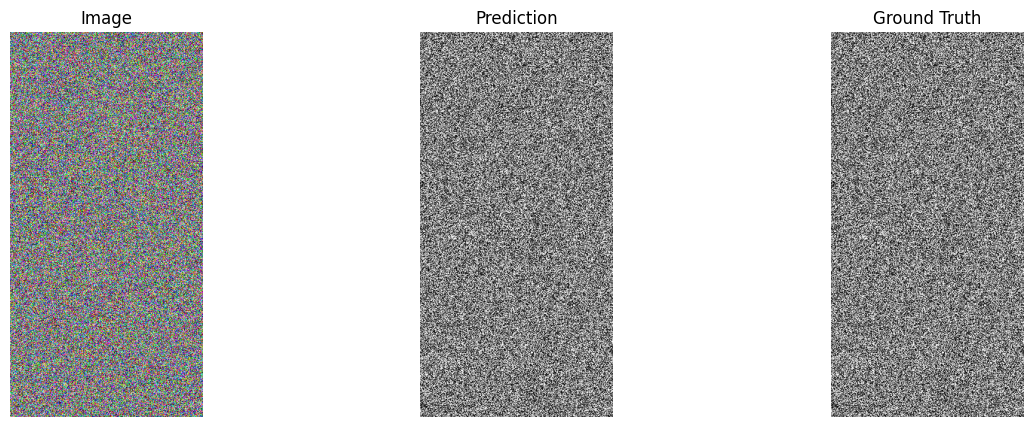

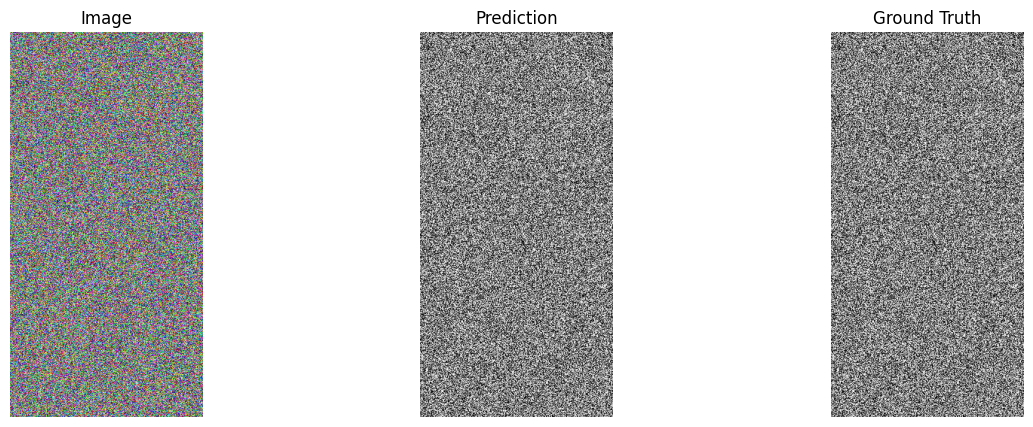

In [34]:
def test_show_before_training():
    # Creating dummy data
    img_height, img_width = 512, 256
    
    # Random RGB image tensor [batch_size, 3, height, width]
    imgs = torch.rand(4, 3, img_height, img_width)

    # Random mask tensor [batch_size, num_classes, height, width]
    outputs = torch.rand(4, 21, img_height, img_width)
    
    # Call the show function to visualize the random data
    show(imgs, outputs, outputs)

# Test the show function with dummy data
test_show_before_training()

In [35]:
# def train_model(model, train_loader, val_loader, num_epochs, device, criterion, optimizer, patience=25):
#     best_val_loss = float('inf')
#     early_stopping_counter = 0  

#     train_losses = []
#     val_losses = []

#     for epoch in range(num_epochs):
#         # --- TRAINING PHASE ---
#         model.train()
#         running_loss = 0.0
#         for inputs, labels in tqdm(train_loader):
#             inputs = inputs.to(device)
#             labels = labels.to(device)

#             # Zero the parameter gradients
#             optimizer.zero_grad()
            
#             # Forward pass
#             outputs = model(inputs)

# #             print(inputs.shape)
# #             print(labels.shape)
# #             print(outputs.shape)

#             # Compute loss
#             loss = criterion(outputs, labels)
            
#             # Backward pass
#             loss.backward()
            
#             optimizer.step()

#             running_loss += loss.item()
        
#         if(epoch%5 == 0):
#             print("Training Output")
#             show(inputs,outputs,labels)
            
#         # --- VALIDATION PHASE ---
#         model.eval()
#         val_loss = 0.0
#         with torch.no_grad():
#             for inputs, labels in tqdm(val_loader):
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)

#                 # Forward pass
             
#                 outputs = model(inputs)
#                 val_loss += criterion(outputs, labels).item()
            
#             if(epoch%5 == 0):
#                 print("Validation Output")
#                 show(inputs,outputs,labels)

#         train_loss = running_loss / len(train_loader)
#         val_loss /= len(val_loader)

#         train_losses.append(train_loss)
#         val_losses.append(val_loss)

#         print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             torch.save(model.state_dict(), 'UNET.pth')
#             early_stopping_counter = 0
#         else:
#             early_stopping_counter += 1

#         if early_stopping_counter >= patience:
#             print("Early stopping triggered.")
#             break

#     print('Finished Training')
#     return train_losses, val_losses

In [36]:
def train_model(model, train_loader, val_loader, num_epochs, device, criterion, optimizer, patience=25):
    best_val_loss = float('inf')
    early_stopping_counter = 0  

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        # --- TRAINING PHASE ---
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader):
            # inputs: [batch_size, num_crops, channels, height, width]
            # labels: [batch_size, num_crops, height, width] or [batch_size, num_crops, num_classes, height, width]
            
            # Transfer inputs and labels to device (GPU/TPU)
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Loop through each crop
            for i in range(inputs.size(1)):  # Iterate over the num_crops dimension
                img = inputs[:, i, :, :, :]  # Shape: [batch_size, channels, height, width]
                msk = labels[:, i, :, :]  # Shape: [batch_size, height, width] or [batch_size, num_classes, height, width]
                
                # Forward pass
                outputs = model(img)  # Model output

                # Compute loss
                loss = criterion(outputs, msk)

                # Backward pass and optimization
                loss.backward()
                optimizer.step()

                # Accumulate loss
                running_loss += loss.item()
        
        if epoch % 5 == 0:
            print("Training Output")
            show(inputs[:, 0, :, :, :], outputs, labels[:, 0, :, :])  # Showing the original image and mask
            
        # --- VALIDATION PHASE ---
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader):
                inputs, labels = inputs.to(device), labels.to(device)

                for i in range(inputs.size(1)):  # Iterate over num_crops dimension
                    img = inputs[:, i, :, :, :]
                    msk = labels[:, i, :, :]

                    # Forward pass
                    outputs = model(img)
                    val_loss += criterion(outputs, msk).item()
                
                if epoch % 5 == 0:
                    print("Validation Output")
                    show(inputs[:, 0, :, :, :], outputs, labels[:, 0, :, :])  # Show original image and mask

        train_loss = running_loss / (len(train_loader) * inputs.size(1))  # Normalize by num_crops
        val_loss /= (len(val_loader) * inputs.size(1))  # Normalize by num_crops

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        # Save the model if validation loss has decreased
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'UNET.pth')
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        # Early stopping condition
        if early_stopping_counter >= patience:
            print("Early stopping triggered.")
            break

    print('Finished Training')
    return train_losses, val_losses

In [37]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = inputs.contiguous()
        targets = targets.contiguous()

        intersection = (inputs * targets).sum(dim=(2, 3))
        dice = (2. * intersection + self.smooth) / (inputs.sum(dim=(2, 3)) + targets.sum(dim=(2, 3)) + self.smooth)

        return 1 - dice.mean()

In [38]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = nn.CrossEntropyLoss()(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return F_loss

In [39]:
class CombinedLoss(nn.Module):
    def __init__(self, weight=None):
        super(CombinedLoss, self).__init__()
        self.dice_loss = DiceLoss()
        self.focal_loss = FocalLoss()

    def forward(self, inputs, targets):
        dice = self.dice_loss(inputs, targets)
        focal = self.focal_loss(inputs, targets)
        return dice + focal

In [40]:
#TODO : Write the evaluation metrics you are going to use
criterion = nn.CrossEntropyLoss()
#criterion = CombinedLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

In [ ]:
train_losses, val_losses = train_model(model, dl_train, dl_val, num_epochs=100,device=device, criterion=criterion, optimizer=optimizer, patience=5)

  0%|          | 2/1904 [10:32<181:04:48, 342.74s/it]

In [ ]:
#TODO : Plot losses and metrics graphs
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()

In [ ]:
#TODO : Test your model and show some samples